<a href="https://colab.research.google.com/github/Jinwooseol/Deep-learning/blob/main/Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Systems Dataset
- UCSD의 실험실 연구 프로젝트에 사용되는 풍부한 데이터 모음에 대한 portal이다.
- Goodreads 책 리뷰, Amazon 제품 리뷰, 바텐딩 데이터, 소셜 미디어 데이터 등과 같이 인기 있는 웹사이트의 정보들은 추천 시스템을 구축하는데 유용하다.
- Data Link: https://cseweb.ucsd.edu/~jmcauley/datasets.html

- 해당 데이터 셋에는 많은 종류의 데이터가 포함되어 있으므로 테스트를 위해 **ModCloth 및 Amazon에서 판매되는 제품 데이터 셋**을 사용한다.
-  데이터에는 추천을 위한 사용자/항목 상호작용도 포함됩니다.

Reference: Addressing Marketing Bias in Product Recommendations
Mengting Wan, Jianmo Ni, Rishabh Misra, Julian McAuley
WSDM, 2020

# Statistical Analysis
- https://github.com/MengtingWan/marketBias/blob/master/analysis.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
rc('pdf', fonttype=42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns)>0:
        tab = tab[columns]
    print('contingency table')
    display(tab)
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expctd = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expcted market size')
    display((tab-expctd).round(2))
    

In [4]:
def chi2_test_by_year(df_review):
    chi, p, _, expctd = chi2_contingency(df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi1, p1, _, expctd1 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year<=2014)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi2, p2, _, expctd2 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2015)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi3, p3, _, expctd3 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2016)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi4, p4, _, expctd4 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year>=2017)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    df = pd.DataFrame(np.array([[chi, p, expctd.sum()],
                                [chi1, p1, expctd1.sum()],
                                [chi2, p2, expctd2.sum()],
                                [chi3, p3, expctd3.sum()],
                                [chi4, p4, expctd4.sum()],]), 
                      columns=['chi2', 'p-value', 'sum'],
                      index=['all', '<=2014', '2015', '2016', '>=2017'])
    display(df.round(3))

In [5]:
def two_way_anova(df_review, metric):
    test3 = sm.stats.anova_lm(ols(metric+' ~ model_attr*user_attr', data=df_review).fit()).values[:3,-2:]
    df = pd.DataFrame(test3, columns=['F-stat', 'p-value'], index=['product', 'user', 'product:user'])
    display(df.round(3))
    return df

In [6]:
def plot_avg_by_segment(df_review, metric, figsize, index=[], dataset='', dump=True):
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby(['user_attr', 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby(['user_attr', 'model_attr'])[metric].sem().unstack()
    if len(index)>0:
        group_rating = group_rating.loc[index]
    group_rating.index = group_rating.index.rename('user identity')
    group_rating.columns = group_rating.columns.rename('product image')
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="YlGnBu", annot_kws={"size": 13},
                cbar=False)
    if dump:
        fig.savefig('./plot/'+dataset+'_'+metric+'_heatmap.pdf', bbox_inches='tight')

# Modcloth

In [8]:
dataset = 'modcloth'

df_review = pd.read_csv('/content/drive/MyDrive/인공지능 학습/Data/Modcloth.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review['fit_score'] = 0.0
df_review['fit_score'].loc[df_review['fit'] == 'Just right'] = 1.0
df_review['fit_score'].loc[df_review['fit'].isna()] = None
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Product Selection vs. Marketing Bias (ModCloth)
- Chi2 test of contingency table

In [9]:
contingency_table(df_review, ['Small', 'Large', 'All'])

contingency table


user_attr,Small,Large,All
model_attr,,,
Small,31800,7038,38838
Small&Large,41361,11327,52688
All,73161,18365,91526


chi2 158.739 p-value 0.0

real market size - expcted market size


user_attr,Small,Large
model_attr,,
Small,754.98,-754.98
Small&Large,-754.98,754.98


In [10]:
chi2_test_by_year(df_review)

,chi2,p-value,sum
all,158.739,0.000,91526.0
<=2014,0.532,0.466,25383.0
2015,66.722,0.000,20241.0
2016,70.816,0.000,21239.0
>=2017,29.046,0.000,24663.0


# Consumer Satisfaction vs. Marketing Bias (ModCloth)
- 2-way ANOVA on rating score

,F-stat,p-value
product,171.914,0.0
user,46.312,0.0
product:user,30.685,0.0


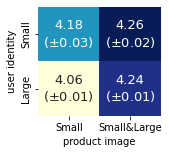

In [11]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (2.2,2), ['Small', 'Large'], dataset, dump=False)

**2-way ANOVA on clothing fit feedback**

,F-stat,p-value
product,293.111,0.000
user,402.441,0.000
product:user,0.000,0.997


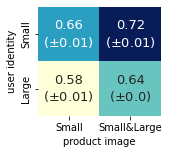

In [12]:
_ = two_way_anova(df_review, 'fit_score')
plot_avg_by_segment(df_review, 'fit_score', (2.2,2), ['Small', 'Large'], dataset, dump=False)

# Amazon Electronics

In [13]:
dataset = 'electronics'
df_review = pd.read_csv('/content/drive/MyDrive/인공지능 학습/Data/Amazon_electronics.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

# Product Selection vs. Marketing Bias (Electronics)
- Chi2 test of contingency table

In [14]:
contingency_table(df_review)

contingency table


user_attr,Female,Male,All
model_attr,,,
Female,34259,31587,65846
Female&Male,26478,24930,51408
Male,25963,30907,56870
All,86700,87424,174124


chi2 581.849 p-value 0.0

real market size - expcted market size


user_attr,Female,Male
model_attr,,
Female,1472.89,-1472.89
Female&Male,880.88,-880.88
Male,-2353.77,2353.77


**Consumer Satisfaction**

,F-stat,p-value
product,62.581,0.000
user,3.508,0.061
product:user,0.907,0.404


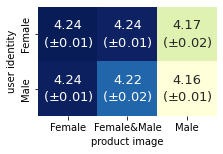

In [15]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (3.2,2), [], dataset, dump=False)